<a name="instructions"></a>
# Instructions

This notebook shows how to analyze the *Real Time Enrollments Excel Report* from the BI system at Loyola University Chicago. While designed for Computer Science, it can be generalized for any department at Loyola.

- Add [my Data@CS](https://drive.google.com/drive/folders/1G-7Rf2nAWdYjX418GuQuM0fK4vw744W7?usp=drive_link) to your Google Drive.
- Go to `Runtime -> Run All` or use your favorite shortcut.
- To see the available reports, you can expand the table of contents.

Note that the reports are not available until the data are loaded in **Select Dataset**. The notebook will pause to wait for your input.

Please reach out to the developer, ``gthiruvathukal@luc.edu``, if you have any questions.



## Add Python Prerequisites

*Colab already comes with a fully-functioning Python environment. These modules are needed for our analysis.*

In [ ]:
!pip install intervaltree

  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=512ef4b5612d45b9a28130968f122be134c230219282b003b39ead2773ca4424
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree


In [ ]:
# Standard Python Libraries

# Systems Needs
import os
import os.path

# Math and Data Handling
import math
import pandas as pd
import numpy

# Database Support
import sqlite3

# CS
import re
import itertools

# Google-Specific needs for Colab
from google.colab import drive
from google.colab import files

# For UX stuff
import ipywidgets as widgets
from IPython.display import display

#
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from intervaltree import Interval, IntervalTree


"All Prerequisites Installed - Keep going!"


'All Prerequisites Installed - Keep going!'

## Mount Enrollment Dataset (via Google Drive)

*Google integration is a key reason to use Colab. You can stage data so the notebook will work regardless of when you run it. Colab notebooks are fired up in cloud instances. So the data you stage are not persistent. By using Google Drive, you can run this notebook whenever you want, as long as your data are staged in your Google Drive.*

In [ ]:
drive_path = '/content/drive'

if not os.path.exists(drive_path):
   drive.mount(drive_path)
else:
   print("Drive already mounted. Possibly harmless!")

my_drive_path = os.path.join(drive_path, 'MyDrive')


Mounted at /content/drive


## Show Google Drive Contents for Data@CS
You *must* use the real-time enrollment report from Loyola's BI system.
Other reports have different headings and will not work....


In [ ]:
!echo "Ensuring availability of Excel files in the Google Folder (sanity check)"

!find /content/drive/MyDrive/Data@CS -name '*.xlsx' -exec basename {} \;

Ensuring availability of Excel files in the Google Folder (sanity check)


## Select Dataset

*Make sure to look past this cell to select the dataset for analysis.*

In [ ]:

data_sets_path = os.path.join(my_drive_path, 'Data@CS')

excel_ls = filter(lambda file: file.endswith('.xlsx'), os.listdir(data_sets_path))
excel_files = list(excel_ls)

print("Menu of Available Files")
for i in range(0, len(excel_files)):
  print(f"{i} = {excel_files[i]}")
print()

while True:
  data_set_input = input("Enter the number of the Excel file you wish to use? ")
  try:
    data_set_index = int(data_set_input)
    if data_set_index not in range(0, len(excel_files)):
      print("Invalid selection. Try again.")
      continue
  except:
    print("Integer expected. Try again!")
    continue

  try:
    data_set_name = excel_files[data_set_index]
  except:
    print("Valid integer expected. Try again.")
    continue
  break

data_set_name

Menu of Available Files
0 = 1246-F24-RealTime-EarlyJune.xlsx
1 = 1246-Real_Time_Class_Enrollments.xlsx

Enter the number of the Excel file you wish to use? 1


'1246-Real_Time_Class_Enrollments.xlsx'

In [ ]:
print(f"""You selected "{data_set_name}".""")

You selected "1246-Real_Time_Class_Enrollments.xlsx".


## Transform Excel into Embedded Database and Data Frame (Pandas)

This code will only work if the Excel spreadsheet comes from the Real-Time Enrollment report. Don't use other BI reports.

In [ ]:
# Load the .xlsx file into a pandas DataFrame
print(data_set_name)
excel_data = pd.read_excel(os.path.join(data_sets_path, data_set_name))
db_filename = 'enrollments.db'

# Please do not change this to False.
fix_headers = True
if fix_headers:
  new_columns = [ column.replace(' ','_').replace('\n','_') for column in excel_data.columns ]
  new_columns = [ re.sub(r'^_+', '', column) for column in new_columns ]
  new_columns = [ re.sub('__+', '_', column) for column in new_columns ]
else:
  new_columns = excel_data.columns.copy()


# Print all column labels [from .db version]

print("Available Columns for Queries:")
print("\n".join(new_columns))

assert len(new_columns) == len(excel_data.columns), "Number of new headers must match number of columns"

# Rename columns
excel_data.columns = new_columns

# Create a new SQLite database connection
conn = sqlite3.connect(db_filename)

# Write the data to a table named 'your_table_name' in the SQLite database
excel_data.to_sql('schedule', conn, if_exists='replace', index=False)

# Commit any changes and close the connection
conn.commit()
conn.close()



1246-Real_Time_Class_Enrollments.xlsx
Available Columns for Queries:
STRM
SESSION_CODE
SUBJECT
CATALOG_NUMBER
SECTION
CLASS_TITLE
COMPONENT
INSTRUCTOR
ENROLL_CAP
ENROLL_TOTAL
SEATS_REMAINING
ENROLLMENT_PCT
ROOM_CAP_PCT
ROOM_CAP
CLASS_LOCATION
FACILITY
CLASS_STATUS
MEETING_PATTERN
CLASS_START_TIME
CLASS_END_TIME
CORE_AREAS
CORE_2012
CROSSLISTING
CORE_AREAS_FLG
CORE_2012_FLAG


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:241: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Reporting

This section contains key reports needed by the department chair.

<a name="show-course-schedule-code"></a>
## Show Course Schedule - Code

*Extraneous details are omitted.*



In [ ]:
from IPython.display import display, HTML

def print_colored(text, color='black', emphasis=True):
    # Use the <b> tag for bold emphasis if needed
    if emphasis:
        text = f"<b>{text}</b>"
    # Display the HTML content with color
    display(HTML(f"<p style='color: {color};'>{text}</p>"))


def set_default_styling(group):

    group.style.set_table_styles([
      {'selector': 'th', 'props': [('text-align', 'left'), ('width', '100px')]},
    ]).applymap(lambda x: 'text-align: left;', subset=pd.IndexSlice[:, :])

"Success"

'Success'

In [ ]:
def get_styled_group(group):
  return group.style.set_table_styles(
    [{'selector': 'th',
      'props': [('text-align', 'left'), ('width', '150px')]},
     {'selector': 'td',
      'props': [('text-align', 'left'), ('width', '150px')]}
    ]
  )

"Success"


'Success'

In [ ]:

conn = sqlite3.connect(db_filename)

# While this query might at first blush appear unnecessary, there is no point in including any of these course sections
# in the dataframe (and subsequent reports).
# The second "and" involving CATALOG_NUMBER excludes things we do not actually control (Math, Neuroscience, Bioinformatics)

depts = ["COMP"]

# You can add other departments to the report by creating a department-specific filter.
# Make sure you create a filter for each department (e.g. musc_filter) and add this filter to the dictionary of dept_filters.

comp_filter = """
      SUBJECT = 'COMP'
        and
      CATALOG_NUMBER not in ('391', '398', '490', '499', '605')
        and
      CATALOG_NUMBER not in ('215', '231', '331', '431', '381', '386', '383', '483')
        and
      SECTION not in ('01L', '02L', '03L', '04L', '05L', '06L', '700N')
"""

dept_filters = {
    'COMP' : comp_filter
}

where_clause = "\n  WHERE " + " or ".join([ '(' + dept_filters[filter] + ')' for filter in dept_filters ])

query = """
   SELECT
      SUBJECT,
      CATALOG_NUMBER,
      SUBJECT || "-" || CATALOG_NUMBER as FQ_CATALOG_NUMBER,
      CATALOG_NUMBER || '-' || SECTION as FQ_CLASS_SECTION,
      CLASS_TITLE,
      INSTRUCTOR,
      ENROLL_TOTAL,
      MEETING_PATTERN,
      CLASS_START_TIME,
      CLASS_END_TIME,
      FACILITY,
      '(' || INSTRUCTOR || ',' || FACILITY || ',' || MEETING_PATTERN || ',' ||CLASS_START_TIME || ',' || CLASS_END_TIME || ')' as COMBINED_ID
   FROM
      schedule """ + where_clause

query = query.strip()
#print(query)

df = pd.read_sql_query(query, conn)
conn.close()

pd.options.display.max_rows = 999

df2 = df.drop_duplicates(subset=['FQ_CLASS_SECTION'])

df2 = df2.copy()


unknown_instructor_name = 'Turing,Alan' # This has long been our "default" for unassigned courses. I don't expect anyone with this name to be on faculty.
df2['INSTRUCTOR'].fillna(unknown_instructor_name, inplace=True)

unknown_combined_id = '(Doyle Center, No Start Time, No End Time)'
df2['COMBINED_ID'].fillna(unknown_combined_id, inplace=True)

def traditional_meeting_pattern(row):
    meeting_pattern = row['MEETING_PATTERN']
    if meeting_pattern:
      return meeting_pattern.replace('TR', 'R').replace('SA', 'S').replace('SU', 'X') # Remove all 2-letter codes and follow MTWRFSX format.
    else:
      return ""

def time_to_minutes(t):
    return t.hour * 60 + t.minute

def unit_class_duration(row):
  start = row['CLASS_START_TIME']
  end = row['CLASS_END_TIME']

  if not start or not end:
    return 0
  start_time = datetime.strptime(start, '%H:%M:%S')
  end_time = datetime.strptime(end, '%H:%M:%S')
  start_minutes = time_to_minutes(start_time)
  end_minutes = time_to_minutes(end_time)
  total_minutes = end_minutes - start_minutes
  return total_minutes


def instructional_time(row):
  meeting_pattern = row['TRAD_MEETING_PATTERN']
  return len(meeting_pattern) * row['UNIT_CLASS_DURATION']

#df2 = df2.copy()
# Really bad LOCUS thing: M,T,W,TR,F,SA
# I'm using M,T,W,T,F. If we ever use SU it would become X to denote why we shouldn't do it.

df2['TRAD_MEETING_PATTERN'] = df2.apply(traditional_meeting_pattern, axis=1)

# A bit of data cleansing just to remove the unwanted time information from the Excel to SQLLite3 conversion.

df2['CLASS_START_TIME'] = df['CLASS_START_TIME'].str.split(' ').str[1]
df2['CLASS_END_TIME'] = df['CLASS_END_TIME'].str.split(' ').str[1]
df2['COMBINED_ID'] = df['COMBINED_ID'].str.replace('1900-01-01','')

df2['UNIT_CLASS_DURATION'] = df2.apply(unit_class_duration, axis=1)
df2['INSTRUCTIONAL_TIME'] = df2.apply(instructional_time, axis=1)

#key_fields_of_interest = ['SUBJECT','CATALOG_NUMBER','FQ_CATALOG_NUMBER','FQ_CLASS_SECTION', 'CLASS_TITLE', 'INSTRUCTOR', 'ENROLL_TOTAL', 'MEETING_PATTERN','CLASS_START_TIME','CLASS_END_TIME', 'FACILITY','COMBINED_ID']
FILTER_FIELDS = ['FQ_CLASS_SECTION', 'CLASS_TITLE', 'INSTRUCTOR', 'ENROLL_TOTAL', 'TRAD_MEETING_PATTERN', 'INSTRUCTIONAL_TIME', 'MEETING_PATTERN', 'UNIT_CLASS_DURATION', 'CLASS_START_TIME','CLASS_END_TIME', 'FACILITY', 'COMBINED_ID']

# Now 'df' holds the contents of 'your_table' as a Pandas DataFrame
# Filter out any sectinos with 0. If enrollment is 0, likely to be cancelled anyway.
group = df2[ df2['ENROLL_TOTAL'] >= 0 ]



<a name="show-course-schedule"></a>
## Show Course Schedule - Report

In [ ]:
# Use the Styler to apply CSS
df2 = group
get_styled_group(df2[FILTER_FIELDS])

,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,TRAD_MEETING_PATTERN,INSTRUCTIONAL_TIME,MEETING_PATTERN,UNIT_CLASS_DURATION,CLASS_START_TIME,CLASS_END_TIME,FACILITY,COMBINED_ID
0,100T-001,Computer Science Advising,"Chan-Tin,David Eric",0,,0,None,0,None,None,None,None
1,112-001,Technology Ensemble,"Turing,Alan",1,R,150,TR,150,16:15:00,18:45:00,DU 238,None
2,122-001,Introduction to Digital Music,"Wetzel,David",8,TR,150,TTR,75,13:00:00,14:15:00,MUND1017,"(Wetzel,David,MUND1017,TTR, 13:00:00, 14:15:00)"
3,122-003,Introduction to Digital Music,"Wetzel,David",26,TR,150,TTR,75,14:30:00,15:45:00,CL 318,"(Wetzel,David,CL 318,TTR, 14:30:00, 15:45:00)"
4,125-001,Visual Information Processing,"Durston,Jonathan",20,R,150,TR,150,18:30:00,21:00:00,CH 002,"(Durston,Jonathan,CH 002,TR, 18:30:00, 21:00:00)"
5,125-002,Visual Information Processing,"Nguyen,Vincent",24,TR,150,TTR,75,13:15:00,14:30:00,CH 311,"(Nguyen,Vincent,CH 311,TTR, 13:15:00, 14:30:00)"
6,141-001,Introduction to Computing Tool,"Moreira,Daniel",30,T,75,T,75,16:15:00,17:30:00,None,None
7,141-002,Introduction to Computing Tool,"O'Sullivan,John Nikolas",18,M,75,M,75,17:30:00,18:45:00,None,None
8,141-003,Introduction to Computing Tool,"Thiruvathukal,George",26,W,75,W,75,16:15:00,17:30:00,ONLINE,"(Thiruvathukal,George,ONLINE,W, 16:15:00, 17:30:00)"
9,141-004,Introduction to Computing Tool,"Turing,Alan",11,R,75,TR,75,16:15:00,17:30:00,ONLINE,None


<a name="show-online"></a>
## Show Online Only Courses - Report

We schedule COMP 141 online with a sync session
Besides COMP 141, we schedule any IT/professional courses online. These typically support MS IT.

In [ ]:
df3 = df2 [ df2['FACILITY'] == 'ONLINE']
get_styled_group(df3[FILTER_FIELDS])

,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,TRAD_MEETING_PATTERN,INSTRUCTIONAL_TIME,MEETING_PATTERN,UNIT_CLASS_DURATION,CLASS_START_TIME,CLASS_END_TIME,FACILITY,COMBINED_ID
8,141-003,Introduction to Computing Tool,"Thiruvathukal,George",26,W,75,W,75,16:15:00,17:30:00,ONLINE,"(Thiruvathukal,George,ONLINE,W, 16:15:00, 17:30:00)"
9,141-004,Introduction to Computing Tool,"Turing,Alan",11,R,75,TR,75,16:15:00,17:30:00,ONLINE,None
10,141-005,Introduction to Computing Tool,"O'Sullivan,John Nikolas",9,M,75,M,75,16:15:00,17:30:00,ONLINE,"(O'Sullivan,John Nikolas,ONLINE,M, 16:15:00, 17:30:00)"
11,141-006,Introduction to Computing Tool,"Turing,Alan",6,W,75,W,75,17:30:00,18:45:00,ONLINE,None
29,301-001,Intro Computer Security,"Abuhamad,Mohammed",33,M,150,M,150,16:15:00,18:45:00,ONLINE,"(Abuhamad,Mohammed,ONLINE,M, 16:15:00, 18:45:00)"
30,301-002,Intro Computer Security,"Abuhamad,Mohammed",30,W,150,W,150,16:15:00,18:45:00,ONLINE,"(Abuhamad,Mohammed,ONLINE,W, 16:15:00, 18:45:00)"
31,306-001,Data Mining,"Turing,Alan",11,W,150,W,150,17:30:00,20:00:00,ONLINE,None
45,341-001,Human-Computer Interaction,"Hayward,Nicholas J",12,M,150,M,150,17:30:00,20:00:00,ONLINE,"(Hayward,Nicholas J,ONLINE,M, 17:30:00, 20:00:00)"
46,343-001,Computer Networks,"Dordal,Peter L",33,T,180,T,180,18:00:00,21:00:00,ONLINE,"(Dordal,Peter L,ONLINE,T, 18:00:00, 21:00:00)"
47,347-001,Intrusion Detection & Security,"Schmitz,Corby",28,F,150,F,150,17:45:00,20:15:00,ONLINE,"(Schmitz,Corby,ONLINE,F, 17:45:00, 20:15:00)"


In [ ]:
schedule_df = group # just so we know what group represents at this point... (will refactor names later)

['08:00', '08:05', '08:10', '08:15', '08:20', '08:25', '08:30', '08:35', '08:40', '08:45', '08:50', '08:55', '09:00', '09:05', '09:10', '09:15', '09:20', '09:25', '09:30', '09:35', '09:40', '09:45', '09:50', '09:55', '10:00', '10:05', '10:10', '10:15', '10:20', '10:25', '10:30', '10:35', '10:40', '10:45', '10:50', '10:55', '11:00', '11:05', '11:10', '11:15', '11:20', '11:25', '11:30', '11:35', '11:40', '11:45', '11:50', '11:55', '12:00', '12:05', '12:10', '12:15', '12:20', '12:25', '12:30', '12:35', '12:40', '12:45', '12:50', '12:55', '13:00', '13:05', '13:10', '13:15', '13:20', '13:25', '13:30', '13:35', '13:40', '13:45', '13:50', '13:55', '14:00', '14:05', '14:10', '14:15', '14:20', '14:25', '14:30', '14:35', '14:40', '14:45', '14:50', '14:55', '15:00', '15:05', '15:10', '15:15', '15:20', '15:25', '15:30', '15:35', '15:40', '15:45', '15:50', '15:55', '16:00', '16:05', '16:10', '16:15', '16:20', '16:25', '16:30', '16:35', '16:40', '16:45', '16:50', '16:55', '17:00', '17:05', '17:10', 

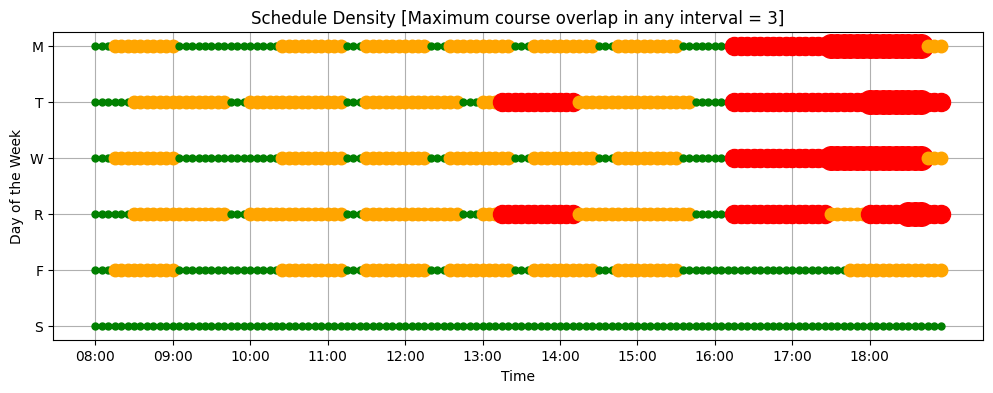

In [ ]:
def time_to_minutes(t):
    return t.hour * 60 + t.minute

# One of the most important data structures (hope we're teaching it)
def create_interval_trees(schedule):
    day_trees = {day: IntervalTree() for day in ['M', 'T', 'W', 'R', 'F', 'S']}
    #print(day_trees)
    for (index, row) in schedule_df.iterrows():
        pattern = row['TRAD_MEETING_PATTERN']
        start = row['CLASS_START_TIME']
        end = row['CLASS_END_TIME']
        if start == end:
          continue
        start_time = datetime.strptime(start, '%H:%M:%S')
        end_time = datetime.strptime(end, '%H:%M:%S')
        start_minutes = time_to_minutes(start_time)
        end_minutes = time_to_minutes(end_time)
        total_minutes = 0
        for day in pattern: # e.g. ('M', 'W', 'F') iterates as 'M','W','F'
           interval = Interval(start_minutes, end_minutes)
           try:
              day_trees[day].add(interval)
              total_minutes += (end_minutes - start_minutes)
           except:
              print(interval, start_time, end_time, pattern)
        if total_minutes != 150: #TODO: We need # credits to know the correct answer but this catches MOST
          print("Checking for duraton != 150 minutes (possibly ok): ", row['FQ_CLASS_SECTION'], row['TRAD_MEETING_PATTERN'], row['CLASS_START_TIME'], row['CLASS_END_TIME'])
    return day_trees

def plot_schedule_with_overlap(schedule, overlap_threshold = 2):
    fig, ax = plt.subplots(figsize=(12, 4))
    days = ['M', 'T', 'W', 'R', 'F', 'S']
    days.reverse() # For more natural appearance on the chart.
    day_positions = range(len(days))
    times = [datetime(2023, 1, 1, hour, minute)
      for hour in range(8, 19)
        for minute in range(0, 60, 5)] #todo remove hard-coding of year/1/1 (safe though)
    time_labels = [t.strftime('%H:%M') for t in times]
    print(time_labels)
    day_trees = create_interval_trees(schedule)

    max_overlap = 0
    for day_index, day in enumerate(days):
        for t in times:
            minutes = time_to_minutes(t)
            overlaps = day_trees[day][minutes]
            color = 'orange' if overlaps else 'green'
            if len(overlaps) >=max_overlap:
              max_overlap = len(overlaps)
            if len(overlaps) >= overlap_threshold:
              color = 'red'
            size = 5 + 4 * len(overlaps)  # Base size + additional size for each overlap
            #print(day_index, day, t, overlaps)
            #ax.plot(day_index, minutes, color=color, marker='o', markersize=size)
            ax.plot(minutes, day_index, color=color, marker='o', markersize=size)  # Swapped day_index and minutes

    # Setting axis labels and ticks
    ax.set_yticks(day_positions)
    ax.set_yticklabels(days)
    ax.set_xticks([time_to_minutes(t) for t in times][::12])  # Every hour
    ax.set_xticklabels(time_labels[::12])
    ax.set_ylabel('Day of the Week')
    ax.set_xlabel('Time')


    # ax.set_xticks(day_positions)
    # ax.set_xticklabels(days)
    # ax.set_yticks([time_to_minutes(t) for t in times][::12])  # Every hour
    # ax.set_yticklabels(time_labels[::12])
    # ax.set_xlabel('Days of the Week')
    # ax.set_ylabel('Time')
    ax.set_title('Schedule Density [Maximum course overlap in any interval = %(max_overlap)d]' % vars())
    ax.grid(True)
    return fig


# Plot the schedule with varying marker size based on overlap
fig = plot_schedule_with_overlap(schedule_df)

# Show the plot
plt.show()


<a name="show-course-health-code"></a>
## Show Course Enrollment Health - Code

*Graduate enrollments are weighted at 5/3 of undergrad enrollments. This report should also be used to prioritize TA support, subject to making sure all foundational CS courses have proper TA support (100 and 200 level)*


In [ ]:
# Note: We assume a lexicographic ordering here as we have sections with letter codes (400A, 400B, etc.)
def weighted_enrollment(row):
    if '300' <= row['CATALOG_NUMBER'] < '400':
        return row['ENROLL_TOTAL'] * 1.0
    elif '400' <= row['CATALOG_NUMBER']:
        return row['ENROLL_TOTAL'] * 5/3
    else:
        return row['ENROLL_TOTAL']

df2 = df2.copy()
df2['WEIGHTED_ENROLL_TOTAL'] = df2.apply(weighted_enrollment, axis=1)

def sch_weighted(row):
  credits = 3
  if row['CATALOG_NUMBER'] in set(['395']):
    credits = 1
  return int(credits * row['WEIGHTED_ENROLL_TOTAL'])

df2['WEIGHTED_SCH_TOTAL'] = df2.apply(sch_weighted, axis=1)

combined_groups = df2.groupby('COMBINED_ID')

report = []
for name, group in combined_groups:
    report.append((group['WEIGHTED_ENROLL_TOTAL'].sum(), name, group))

report.sort(reverse=False)

FILTER_FIELDS = ['FQ_CLASS_SECTION', 'CLASS_TITLE', 'INSTRUCTOR', 'ENROLL_TOTAL', 'MEETING_PATTERN','CLASS_START_TIME','CLASS_END_TIME']



## Show Course Enrollment Health - Report

In [ ]:
for entry in report:
    (group_sum, name, group) = entry
    display(HTML(f"<h3>{name}</h3>"))
    if group_sum < 12:
      group_color = 'red'
    elif group_sum < 32:
      group_color = 'green'
    else:
      group_color = 'blue'

    print_colored(f"Weighted Enrollments = {int(group_sum)}", group_color)
    #inner_group = group[['FQ_CLASS_SECTION', 'CLASS_TITLE', 'INSTRUCTOR', 'ENROLL_TOTAL', 'FACILITY']]
    inner_group = group[FILTER_FIELDS]
    set_default_styling(inner_group)
    display(get_styled_group(inner_group[FILTER_FIELDS]))
    display(HTML('<hr/>'))



,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
61,399-001,Computer Science Seminar,"Abuhamad,Mohammed",2,F,12:35:00,13:25:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
19,170-002,Intro Obj-Oriented Prog,"Honig,William",2,MWF,10:25:00,11:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
21,180-001,Computing & Data for Sciences,"Rusniak,Kathy Jo",4,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
40,326-001,Digital Music Programming,"Wetzel,David",4,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
37,321-001,Modeling and Simulation,"Matthews,Gregory J.",0,TTR,11:30:00,12:45:00
76,421-001,Math Models & Simulation,"Matthews,Gregory J.",3,TTR,11:30:00,12:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
43,336-001,Markup Languages,"Hayward,Nicholas J",0,W,16:15:00,18:45:00
80,436-001,Markup Languages,"Hayward,Nicholas J",4,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
2,122-001,Introduction to Digital Music,"Wetzel,David",8,TTR,13:00:00,14:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
10,141-005,Introduction to Computing Tool,"O'Sullivan,John Nikolas",9,M,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
22,251-001,Intro to Database Systems,"Bevente,Guy",15,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
16,163-005,Discrete Structures,"Wang,TaiNing",15,TTR,08:30:00,09:45:00
67,400E-001,Discrete Structures,"Wang,TaiNing",0,TTR,08:30:00,09:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
54,373-001,Adv Object-Oriented Prog,"Laufer,Konstantin",9,TR,16:15:00,18:45:00
92,473-001,Adv. Object Oriented Prog.,"Laufer,Konstantin",5,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
57,388-002,Topics:,"Moreira,Daniel",1,MW,16:15:00,17:30:00
95,488-002,Top:,"Moreira,Daniel",10,MW,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
4,125-001,Visual Information Processing,"Durston,Jonathan",20,TR,18:30:00,21:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
88,460-001,Algorithms & Complexity,"Irakliotis,Leo",12,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
102,377-001,IT Project Management,"Kabani,Karim",9,TR,18:00:00,21:00:00
103,477-001,IT Project Management,"Kabani,Karim",7,TR,18:00:00,21:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
5,125-002,Visual Information Processing,"Nguyen,Vincent",24,TTR,13:15:00,14:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
8,141-003,Introduction to Computing Tool,"Thiruvathukal,George",26,W,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
3,122-003,Introduction to Digital Music,"Wetzel,David",26,TTR,14:30:00,15:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
20,170-003,Intro Obj-Oriented Prog,"Yacobellis,Robert",26,TTR,16:15:00,17:30:00
63,400A-003,Obj-Oriented Prgmg,"Yacobellis,Robert",0,TTR,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
38,322-001,Software Dev. Wireless&Mobile,"Hayward,Nicholas J",14,TTR,14:30:00,15:45:00
77,422-001,Wireless/Mobile Softw Dev,"Hayward,Nicholas J",8,TTR,14:30:00,15:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
39,324-001,Client-Side Web Development,"Hayward,Nicholas J",7,T,19:00:00,21:30:00
78,424-001,Client-Side Web Design,"Hayward,Nicholas J",13,T,19:00:00,21:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
45,341-001,Human-Computer Interaction,"Hayward,Nicholas J",12,M,17:30:00,20:00:00
82,441-001,Human-Computer Interaction,"Hayward,Nicholas J",10,M,17:30:00,20:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
30,301-002,Intro Computer Security,"Abuhamad,Mohammed",30,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
13,150-002,Introduction to Computing,"Miller,Allan Jay",30,T,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
12,150-001,Introduction to Computing,"Miller,Allan Jay",30,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
49,353-001,Database Programming,"Silva,Yasin",30,TTR,10:00:00,11:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
14,150-003,Introduction to Computing,"Viswanathan,Kylash",30,TTR,08:30:00,09:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
17,163-006,Discrete Structures,"Wang,TaiNing",30,TTR,10:00:00,11:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
36,317-002,SocialLegal&EthicIssuComp,"Bergman,Smadar K",31,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
52,363-002,Desgn/Anlys Comp Algorthm,"Irakliotis,Leo",31,MWF,13:40:00,14:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
28,272-002,Data Structures II,"O'Connell,William",31,TTR,13:00:00,14:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
86,453-001,Database Programming,"Silva,Yasin",19,TTR,14:30:00,15:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
35,317-001,SocialLegal&EthicIssuComp,"Bergman,Smadar K",32,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
27,272-001,Data Structures II,"O'Connell,William",26,TTR,11:30:00,12:45:00
65,400C-001,Data Structures II,"O'Connell,William",4,TTR,11:30:00,12:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
25,271-001,Data Structures I,"Irakliotis,Leo",33,MWF,08:15:00,09:05:00
64,400B-001,Data Structures I,"Irakliotis,Leo",0,MWF,08:15:00,09:05:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
75,417-001,Social & Ethical Iss Comp,"Dordal,Peter L",20,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
26,271-002,Data Structures I,"Irakliotis,Leo",34,MWF,11:30:00,12:20:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
24,264-002,Intro to Computer Systems,"Greenberg,Ronald I",35,MWF,11:30:00,12:20:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
18,170-001,Intro Obj-Oriented Prog,"Yacobellis,Robert",30,TTR,11:30:00,12:45:00
62,400A-001,Obj-Oriented Prgmg,"Yacobellis,Robert",3,TTR,11:30:00,12:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
32,310-001,Operating Systems,"Klingensmith,Neil",31,MW,16:15:00,17:30:00
72,410-001,Operating Systems,"Klingensmith,Neil",3,MW,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
33,312-01E,Open Source Software Practicum,"Dordal,Peter L",29,MW,12:35:00,13:25:00
73,412-001,Open Source Computing,"Dordal,Peter L",5,MW,12:35:00,13:25:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
44,340-001,Computer Forensics,"Janton,Kamil",22,TR,16:15:00,18:45:00
81,440-001,Comp Forensics Investigations,"Janton,Kamil",10,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
34,313-001,Object-Oriented Design,"Yacobellis,Robert",19,TTR,13:00:00,14:15:00
74,413-001,Intermed Object-Orientd Devel,"Yacobellis,Robert",13,TTR,13:00:00,14:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
48,352-001,Computer Vulnerabilities,"Chan-Tin,David Eric",24,M,16:15:00,18:45:00
85,452-001,Intro Comp Vulnerabilities,"Chan-Tin,David Eric",11,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
42,330-001,Software Engineering,"Honig,William",36,MWF,11:30:00,12:20:00
93,474-001,Software Engineering,"Honig,William",5,MWF,11:30:00,12:20:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
29,301-001,Intro Computer Security,"Abuhamad,Mohammed",33,M,16:15:00,18:45:00
68,401-001,Computer Security,"Abuhamad,Mohammed",7,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
46,343-001,Computer Networks,"Dordal,Peter L",33,T,18:00:00,21:00:00
83,443-001,Computer Networks,"Dordal,Peter L",9,T,18:00:00,21:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
53,371-001,Programming Languages,"Laufer,Konstantin",47,T,16:15:00,18:45:00
91,471-001,Thry Programmng Languages,"Laufer,Konstantin",4,T,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
47,347-001,Intrusion Detection & Security,"Schmitz,Corby",28,F,17:45:00,20:15:00
84,447-001,Intrusion Detection,"Schmitz,Corby",19,F,17:45:00,20:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
55,379-001,Machine Learning,"Dligach,Dmitriy",25,TR,16:15:00,18:45:00
94,479-001,Machine Learning,"Dligach,Dmitriy",21,TR,16:15:00,18:45:00


In [ ]:
combined_groups = df2.groupby('COMBINED_ID')
trouble_threshold = 10
in_trouble = itertools.count(start=1)
for name, group in combined_groups:
    group_sum = math.ceil(group['WEIGHTED_ENROLL_TOTAL'].sum())
    if group_sum < trouble_threshold:
      in_trouble_val = next(in_trouble)
      group_color = 'green' if group_sum >= 12 else 'red'  # for now
      print_colored(f"Course {in_trouble_val} has {group_sum} enrollments", group_color)
      display(get_styled_group(group[FILTER_FIELDS]))
      display(HTML('<hr/>'))

print_colored(f"Number of sectiions in trouble {in_trouble}")


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
61,399-001,Computer Science Seminar,"Abuhamad,Mohammed",2,F,12:35:00,13:25:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
43,336-001,Markup Languages,"Hayward,Nicholas J",0,W,16:15:00,18:45:00
80,436-001,Markup Languages,"Hayward,Nicholas J",4,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
19,170-002,Intro Obj-Oriented Prog,"Honig,William",2,MWF,10:25:00,11:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
37,321-001,Modeling and Simulation,"Matthews,Gregory J.",0,TTR,11:30:00,12:45:00
76,421-001,Math Models & Simulation,"Matthews,Gregory J.",3,TTR,11:30:00,12:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
10,141-005,Introduction to Computing Tool,"O'Sullivan,John Nikolas",9,M,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
21,180-001,Computing & Data for Sciences,"Rusniak,Kathy Jo",4,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
40,326-001,Digital Music Programming,"Wetzel,David",4,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
2,122-001,Introduction to Digital Music,"Wetzel,David",8,TTR,13:00:00,14:15:00


<a name="show-assignments-by-instructor"></a>
## Show Instructor Assignments - Code and Report

*This is typically known as the "teaching load". I prefer terms such as teaching-intensive vs. research-intensive or "teaching profile", since teaching and research are both greatly valued by the university (and. me).*



In [ ]:
combined_groups = df2.groupby('INSTRUCTOR')

assignments = {}

for name, group in combined_groups:
    display(HTML(f"<h3>{name}</h3><br/>"))
    inner_group = group[['FQ_CLASS_SECTION', 'CLASS_TITLE', 'ENROLL_TOTAL']]

    unique_courses_for_instr = group.groupby('COMBINED_ID', dropna=False)
    didactic_course_count = itertools.count(start=1)
    for inner_name, inner_group in unique_courses_for_instr:
       print_colored(f"Assignment {next(didactic_course_count)}")
       display(get_styled_group(inner_group[FILTER_FIELDS]))

    assignments[name] = next(didactic_course_count)-1
    display(HTML('<hr/>'))



,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
61,399-001,Computer Science Seminar,"Abuhamad,Mohammed",2,F,12:35:00,13:25:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
29,301-001,Intro Computer Security,"Abuhamad,Mohammed",33,M,16:15:00,18:45:00
68,401-001,Computer Security,"Abuhamad,Mohammed",7,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
30,301-002,Intro Computer Security,"Abuhamad,Mohammed",30,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
35,317-001,SocialLegal&EthicIssuComp,"Bergman,Smadar K",32,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
36,317-002,SocialLegal&EthicIssuComp,"Bergman,Smadar K",31,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
22,251-001,Intro to Database Systems,"Bevente,Guy",15,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
48,352-001,Computer Vulnerabilities,"Chan-Tin,David Eric",24,M,16:15:00,18:45:00
85,452-001,Intro Comp Vulnerabilities,"Chan-Tin,David Eric",11,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
0,100T-001,Computer Science Advising,"Chan-Tin,David Eric",0,None,None,None


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
55,379-001,Machine Learning,"Dligach,Dmitriy",25,TR,16:15:00,18:45:00
94,479-001,Machine Learning,"Dligach,Dmitriy",21,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
75,417-001,Social & Ethical Iss Comp,"Dordal,Peter L",20,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
33,312-01E,Open Source Software Practicum,"Dordal,Peter L",29,MW,12:35:00,13:25:00
73,412-001,Open Source Computing,"Dordal,Peter L",5,MW,12:35:00,13:25:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
46,343-001,Computer Networks,"Dordal,Peter L",33,T,18:00:00,21:00:00
83,443-001,Computer Networks,"Dordal,Peter L",9,T,18:00:00,21:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
96,595-001,Thesis Supervision,"Dordal,Peter L",0,None,None,None


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
4,125-001,Visual Information Processing,"Durston,Jonathan",20,TR,18:30:00,21:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
60,395-001,Prof Dev & Career Growth CS/IT,"Gorbett,Samantha",15,W,20:00:00,20:50:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
24,264-002,Intro to Computer Systems,"Greenberg,Ronald I",35,MWF,11:30:00,12:20:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
59,390-01E,Broadening Particip STEM,"Greenberg,Ronald I",25,None,None,None


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
38,322-001,Software Dev. Wireless&Mobile,"Hayward,Nicholas J",14,TTR,14:30:00,15:45:00
77,422-001,Wireless/Mobile Softw Dev,"Hayward,Nicholas J",8,TTR,14:30:00,15:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
39,324-001,Client-Side Web Development,"Hayward,Nicholas J",7,T,19:00:00,21:30:00
78,424-001,Client-Side Web Design,"Hayward,Nicholas J",13,T,19:00:00,21:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
43,336-001,Markup Languages,"Hayward,Nicholas J",0,W,16:15:00,18:45:00
80,436-001,Markup Languages,"Hayward,Nicholas J",4,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
45,341-001,Human-Computer Interaction,"Hayward,Nicholas J",12,M,17:30:00,20:00:00
82,441-001,Human-Computer Interaction,"Hayward,Nicholas J",10,M,17:30:00,20:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
19,170-002,Intro Obj-Oriented Prog,"Honig,William",2,MWF,10:25:00,11:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
42,330-001,Software Engineering,"Honig,William",36,MWF,11:30:00,12:20:00
93,474-001,Software Engineering,"Honig,William",5,MWF,11:30:00,12:20:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
25,271-001,Data Structures I,"Irakliotis,Leo",33,MWF,08:15:00,09:05:00
64,400B-001,Data Structures I,"Irakliotis,Leo",0,MWF,08:15:00,09:05:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
26,271-002,Data Structures I,"Irakliotis,Leo",34,MWF,11:30:00,12:20:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
52,363-002,Desgn/Anlys Comp Algorthm,"Irakliotis,Leo",31,MWF,13:40:00,14:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
88,460-001,Algorithms & Complexity,"Irakliotis,Leo",12,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
44,340-001,Computer Forensics,"Janton,Kamil",22,TR,16:15:00,18:45:00
81,440-001,Comp Forensics Investigations,"Janton,Kamil",10,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
102,377-001,IT Project Management,"Kabani,Karim",9,TR,18:00:00,21:00:00
103,477-001,IT Project Management,"Kabani,Karim",7,TR,18:00:00,21:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
32,310-001,Operating Systems,"Klingensmith,Neil",31,MW,16:15:00,17:30:00
72,410-001,Operating Systems,"Klingensmith,Neil",3,MW,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
53,371-001,Programming Languages,"Laufer,Konstantin",47,T,16:15:00,18:45:00
91,471-001,Thry Programmng Languages,"Laufer,Konstantin",4,T,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
54,373-001,Adv Object-Oriented Prog,"Laufer,Konstantin",9,TR,16:15:00,18:45:00
92,473-001,Adv. Object Oriented Prog.,"Laufer,Konstantin",5,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
37,321-001,Modeling and Simulation,"Matthews,Gregory J.",0,TTR,11:30:00,12:45:00
76,421-001,Math Models & Simulation,"Matthews,Gregory J.",3,TTR,11:30:00,12:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
13,150-002,Introduction to Computing,"Miller,Allan Jay",30,T,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
12,150-001,Introduction to Computing,"Miller,Allan Jay",30,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
57,388-002,Topics:,"Moreira,Daniel",1,MW,16:15:00,17:30:00
95,488-002,Top:,"Moreira,Daniel",10,MW,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
6,141-001,Introduction to Computing Tool,"Moreira,Daniel",30,T,16:15:00,17:30:00
66,400D-001,Computing Tools and Techniques,"Moreira,Daniel",0,T,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
5,125-002,Visual Information Processing,"Nguyen,Vincent",24,TTR,13:15:00,14:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
28,272-002,Data Structures II,"O'Connell,William",31,TTR,13:00:00,14:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
27,272-001,Data Structures II,"O'Connell,William",26,TTR,11:30:00,12:45:00
65,400C-001,Data Structures II,"O'Connell,William",4,TTR,11:30:00,12:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
10,141-005,Introduction to Computing Tool,"O'Sullivan,John Nikolas",9,M,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
7,141-002,Introduction to Computing Tool,"O'Sullivan,John Nikolas",18,M,17:30:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
21,180-001,Computing & Data for Sciences,"Rusniak,Kathy Jo",4,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
47,347-001,Intrusion Detection & Security,"Schmitz,Corby",28,F,17:45:00,20:15:00
84,447-001,Intrusion Detection,"Schmitz,Corby",19,F,17:45:00,20:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
86,453-001,Database Programming,"Silva,Yasin",19,TTR,14:30:00,15:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
49,353-001,Database Programming,"Silva,Yasin",30,TTR,10:00:00,11:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
90,464-001,High-Performance Computing,"Stone,Christopher",18,W,19:00:00,21:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
8,141-003,Introduction to Computing Tool,"Thiruvathukal,George",26,W,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
1,112-001,Technology Ensemble,"Turing,Alan",1,TR,16:15:00,18:45:00
9,141-004,Introduction to Computing Tool,"Turing,Alan",11,TR,16:15:00,17:30:00
11,141-006,Introduction to Computing Tool,"Turing,Alan",6,W,17:30:00,18:45:00
15,163-004,Discrete Structures,"Turing,Alan",13,MWF,14:45:00,15:35:00
23,264-001,Intro to Computer Systems,"Turing,Alan",34,MWF,10:25:00,11:15:00
31,306-001,Data Mining,"Turing,Alan",11,W,17:30:00,20:00:00
41,329-001,Natural Language Processing,"Turing,Alan",3,W,16:15:00,18:45:00
50,358-001,Big Data Analytics,"Turing,Alan",0,T,16:15:00,18:45:00
51,362-001,Computer Architecture,"Turing,Alan",5,MWF,14:45:00,15:35:00
56,388-001,Topics:,"Turing,Alan",0,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
14,150-003,Introduction to Computing,"Viswanathan,Kylash",30,TTR,08:30:00,09:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
17,163-006,Discrete Structures,"Wang,TaiNing",30,TTR,10:00:00,11:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
16,163-005,Discrete Structures,"Wang,TaiNing",15,TTR,08:30:00,09:45:00
67,400E-001,Discrete Structures,"Wang,TaiNing",0,TTR,08:30:00,09:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
3,122-003,Introduction to Digital Music,"Wetzel,David",26,TTR,14:30:00,15:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
40,326-001,Digital Music Programming,"Wetzel,David",4,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
2,122-001,Introduction to Digital Music,"Wetzel,David",8,TTR,13:00:00,14:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
18,170-001,Intro Obj-Oriented Prog,"Yacobellis,Robert",30,TTR,11:30:00,12:45:00
62,400A-001,Obj-Oriented Prgmg,"Yacobellis,Robert",3,TTR,11:30:00,12:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
20,170-003,Intro Obj-Oriented Prog,"Yacobellis,Robert",26,TTR,16:15:00,17:30:00
63,400A-003,Obj-Oriented Prgmg,"Yacobellis,Robert",0,TTR,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
34,313-001,Object-Oriented Design,"Yacobellis,Robert",19,TTR,13:00:00,14:15:00
74,413-001,Intermed Object-Orientd Devel,"Yacobellis,Robert",13,TTR,13:00:00,14:15:00


## Show Number of Assignments per Faculty

This report is helpful for managing full-time and part-time faculty workload (and making sure everyone is duly compensated).

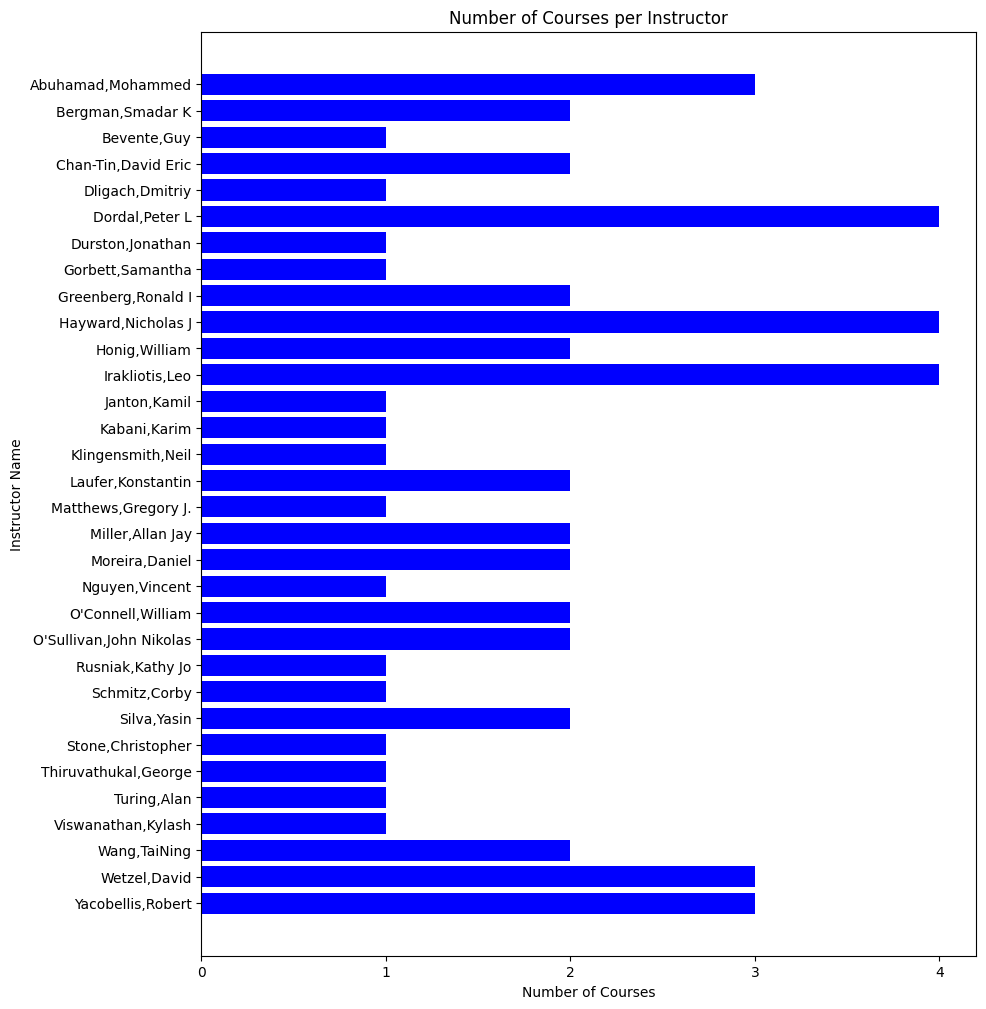

,Instructor Name,Number of Courses
31,"Yacobellis,Robert",3
30,"Wetzel,David",3
29,"Wang,TaiNing",2
28,"Viswanathan,Kylash",1
27,"Turing,Alan",1
26,"Thiruvathukal,George",1
25,"Stone,Christopher",1
24,"Silva,Yasin",2
23,"Schmitz,Corby",1
22,"Rusniak,Kathy Jo",1


In [ ]:
assignments_df = pd.DataFrame.from_dict(assignments, orient='index', columns=['Number of Courses'])
assignments_df.reset_index(inplace=True)
assignments_df.rename(columns={'index': 'Instructor Name'}, inplace=True)
#assignments_df.sort_values(by=['Number of Courses', 'Instructor Name'], ascending=[False, True], inplace=True)
assignments_df.sort_values(by=['Instructor Name'], ascending=[False], inplace=True)
by_instructor = assignments_df
plt.figure(figsize=(10, 12))  # Adjust the size of the plot as needed
plt.barh(by_instructor['Instructor Name'], by_instructor['Number of Courses'], color='blue')  # Horizontal bar chart
plt.ylabel('Instructor Name')
plt.xlabel('Number of Courses')
plt.title('Number of Courses per Instructor')
plt.xticks(range(0, max(assignments_df['Number of Courses']) + 1))  # Assuming number of courses are integers

plt.show()

display(assignments_df)


<a name="show-by-course-number"></a>
## Show by Course Number

*This report allows you to see by course number. This can be helpful for seeing whether we have enough slots for students at the last minute.*



In [ ]:
combined_groups = df2.groupby('FQ_CATALOG_NUMBER')

for name, group in combined_groups:
    display(HTML(f"<h3>{name}</h3>"))
    display(get_styled_group(group[FILTER_FIELDS]))
    display(HTML('<hr/>'))



,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
0,100T-001,Computer Science Advising,"Chan-Tin,David Eric",0,None,None,None


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
1,112-001,Technology Ensemble,"Turing,Alan",1,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
2,122-001,Introduction to Digital Music,"Wetzel,David",8,TTR,13:00:00,14:15:00
3,122-003,Introduction to Digital Music,"Wetzel,David",26,TTR,14:30:00,15:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
4,125-001,Visual Information Processing,"Durston,Jonathan",20,TR,18:30:00,21:00:00
5,125-002,Visual Information Processing,"Nguyen,Vincent",24,TTR,13:15:00,14:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
6,141-001,Introduction to Computing Tool,"Moreira,Daniel",30,T,16:15:00,17:30:00
7,141-002,Introduction to Computing Tool,"O'Sullivan,John Nikolas",18,M,17:30:00,18:45:00
8,141-003,Introduction to Computing Tool,"Thiruvathukal,George",26,W,16:15:00,17:30:00
9,141-004,Introduction to Computing Tool,"Turing,Alan",11,TR,16:15:00,17:30:00
10,141-005,Introduction to Computing Tool,"O'Sullivan,John Nikolas",9,M,16:15:00,17:30:00
11,141-006,Introduction to Computing Tool,"Turing,Alan",6,W,17:30:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
12,150-001,Introduction to Computing,"Miller,Allan Jay",30,TR,16:15:00,18:45:00
13,150-002,Introduction to Computing,"Miller,Allan Jay",30,T,16:15:00,18:45:00
14,150-003,Introduction to Computing,"Viswanathan,Kylash",30,TTR,08:30:00,09:45:00
97,150-800,Introduction to Computing,"Turing,Alan",0,None,None,None


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
15,163-004,Discrete Structures,"Turing,Alan",13,MWF,14:45:00,15:35:00
16,163-005,Discrete Structures,"Wang,TaiNing",15,TTR,08:30:00,09:45:00
17,163-006,Discrete Structures,"Wang,TaiNing",30,TTR,10:00:00,11:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
18,170-001,Intro Obj-Oriented Prog,"Yacobellis,Robert",30,TTR,11:30:00,12:45:00
19,170-002,Intro Obj-Oriented Prog,"Honig,William",2,MWF,10:25:00,11:15:00
20,170-003,Intro Obj-Oriented Prog,"Yacobellis,Robert",26,TTR,16:15:00,17:30:00
98,170-800,Intro Obj-Oriented Prog,"Turing,Alan",0,None,None,None
99,170-801,Intro Obj-Oriented Prog,"Turing,Alan",0,None,None,None
100,170-802,Intro Obj-Oriented Prog,"Turing,Alan",0,None,None,None
101,170-803,Intro Obj-Oriented Prog,"Turing,Alan",0,None,None,None


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
21,180-001,Computing & Data for Sciences,"Rusniak,Kathy Jo",4,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
22,251-001,Intro to Database Systems,"Bevente,Guy",15,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
23,264-001,Intro to Computer Systems,"Turing,Alan",34,MWF,10:25:00,11:15:00
24,264-002,Intro to Computer Systems,"Greenberg,Ronald I",35,MWF,11:30:00,12:20:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
25,271-001,Data Structures I,"Irakliotis,Leo",33,MWF,08:15:00,09:05:00
26,271-002,Data Structures I,"Irakliotis,Leo",34,MWF,11:30:00,12:20:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
27,272-001,Data Structures II,"O'Connell,William",26,TTR,11:30:00,12:45:00
28,272-002,Data Structures II,"O'Connell,William",31,TTR,13:00:00,14:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
29,301-001,Intro Computer Security,"Abuhamad,Mohammed",33,M,16:15:00,18:45:00
30,301-002,Intro Computer Security,"Abuhamad,Mohammed",30,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
31,306-001,Data Mining,"Turing,Alan",11,W,17:30:00,20:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
32,310-001,Operating Systems,"Klingensmith,Neil",31,MW,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
33,312-01E,Open Source Software Practicum,"Dordal,Peter L",29,MW,12:35:00,13:25:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
34,313-001,Object-Oriented Design,"Yacobellis,Robert",19,TTR,13:00:00,14:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
35,317-001,SocialLegal&EthicIssuComp,"Bergman,Smadar K",32,M,16:15:00,18:45:00
36,317-002,SocialLegal&EthicIssuComp,"Bergman,Smadar K",31,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
37,321-001,Modeling and Simulation,"Matthews,Gregory J.",0,TTR,11:30:00,12:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
38,322-001,Software Dev. Wireless&Mobile,"Hayward,Nicholas J",14,TTR,14:30:00,15:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
39,324-001,Client-Side Web Development,"Hayward,Nicholas J",7,T,19:00:00,21:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
40,326-001,Digital Music Programming,"Wetzel,David",4,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
41,329-001,Natural Language Processing,"Turing,Alan",3,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
42,330-001,Software Engineering,"Honig,William",36,MWF,11:30:00,12:20:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
43,336-001,Markup Languages,"Hayward,Nicholas J",0,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
44,340-001,Computer Forensics,"Janton,Kamil",22,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
45,341-001,Human-Computer Interaction,"Hayward,Nicholas J",12,M,17:30:00,20:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
46,343-001,Computer Networks,"Dordal,Peter L",33,T,18:00:00,21:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
47,347-001,Intrusion Detection & Security,"Schmitz,Corby",28,F,17:45:00,20:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
48,352-001,Computer Vulnerabilities,"Chan-Tin,David Eric",24,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
49,353-001,Database Programming,"Silva,Yasin",30,TTR,10:00:00,11:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
50,358-001,Big Data Analytics,"Turing,Alan",0,T,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
51,362-001,Computer Architecture,"Turing,Alan",5,MWF,14:45:00,15:35:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
52,363-002,Desgn/Anlys Comp Algorthm,"Irakliotis,Leo",31,MWF,13:40:00,14:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
53,371-001,Programming Languages,"Laufer,Konstantin",47,T,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
54,373-001,Adv Object-Oriented Prog,"Laufer,Konstantin",9,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
102,377-001,IT Project Management,"Kabani,Karim",9,TR,18:00:00,21:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
55,379-001,Machine Learning,"Dligach,Dmitriy",25,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
56,388-001,Topics:,"Turing,Alan",0,M,16:15:00,18:45:00
57,388-002,Topics:,"Moreira,Daniel",1,MW,16:15:00,17:30:00
58,388-004,Topics:,"Turing,Alan",0,None,None,None


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
59,390-01E,Broadening Particip STEM,"Greenberg,Ronald I",25,None,None,None


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
60,395-001,Prof Dev & Career Growth CS/IT,"Gorbett,Samantha",15,W,20:00:00,20:50:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
61,399-001,Computer Science Seminar,"Abuhamad,Mohammed",2,F,12:35:00,13:25:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
62,400A-001,Obj-Oriented Prgmg,"Yacobellis,Robert",3,TTR,11:30:00,12:45:00
63,400A-003,Obj-Oriented Prgmg,"Yacobellis,Robert",0,TTR,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
64,400B-001,Data Structures I,"Irakliotis,Leo",0,MWF,08:15:00,09:05:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
65,400C-001,Data Structures II,"O'Connell,William",4,TTR,11:30:00,12:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
66,400D-001,Computing Tools and Techniques,"Moreira,Daniel",0,T,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
67,400E-001,Discrete Structures,"Wang,TaiNing",0,TTR,08:30:00,09:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
68,401-001,Computer Security,"Abuhamad,Mohammed",7,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
69,404-001,Organizational Development,"Turing,Alan",0,None,None,None


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
70,405-001,Database Administration,"Turing,Alan",9,T,17:30:00,20:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
71,406-001,Data Mining,"Turing,Alan",17,W,17:30:00,20:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
72,410-001,Operating Systems,"Klingensmith,Neil",3,MW,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
73,412-001,Open Source Computing,"Dordal,Peter L",5,MW,12:35:00,13:25:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
74,413-001,Intermed Object-Orientd Devel,"Yacobellis,Robert",13,TTR,13:00:00,14:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
75,417-001,Social & Ethical Iss Comp,"Dordal,Peter L",20,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
76,421-001,Math Models & Simulation,"Matthews,Gregory J.",3,TTR,11:30:00,12:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
77,422-001,Wireless/Mobile Softw Dev,"Hayward,Nicholas J",8,TTR,14:30:00,15:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
78,424-001,Client-Side Web Design,"Hayward,Nicholas J",13,T,19:00:00,21:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
79,429-001,Natural Lang Proc,"Turing,Alan",3,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
80,436-001,Markup Languages,"Hayward,Nicholas J",4,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
81,440-001,Comp Forensics Investigations,"Janton,Kamil",10,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
82,441-001,Human-Computer Interaction,"Hayward,Nicholas J",10,M,17:30:00,20:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
83,443-001,Computer Networks,"Dordal,Peter L",9,T,18:00:00,21:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
84,447-001,Intrusion Detection,"Schmitz,Corby",19,F,17:45:00,20:15:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
85,452-001,Intro Comp Vulnerabilities,"Chan-Tin,David Eric",11,M,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
86,453-001,Database Programming,"Silva,Yasin",19,TTR,14:30:00,15:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
87,458-001,Big Data Analytics,"Turing,Alan",0,T,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
88,460-001,Algorithms & Complexity,"Irakliotis,Leo",12,W,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
89,462-001,Adv Computer Architecture,"Turing,Alan",3,MWF,14:45:00,15:35:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
90,464-001,High-Performance Computing,"Stone,Christopher",18,W,19:00:00,21:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
91,471-001,Thry Programmng Languages,"Laufer,Konstantin",4,T,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
92,473-001,Adv. Object Oriented Prog.,"Laufer,Konstantin",5,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
93,474-001,Software Engineering,"Honig,William",5,MWF,11:30:00,12:20:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
103,477-001,IT Project Management,"Kabani,Karim",7,TR,18:00:00,21:00:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
94,479-001,Machine Learning,"Dligach,Dmitriy",21,TR,16:15:00,18:45:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
95,488-002,Top:,"Moreira,Daniel",10,MW,16:15:00,17:30:00


,FQ_CLASS_SECTION,CLASS_TITLE,INSTRUCTOR,ENROLL_TOTAL,MEETING_PATTERN,CLASS_START_TIME,CLASS_END_TIME
96,595-001,Thesis Supervision,"Dordal,Peter L",0,None,None,None


## Teaching Distribution by Weighted Enrollment

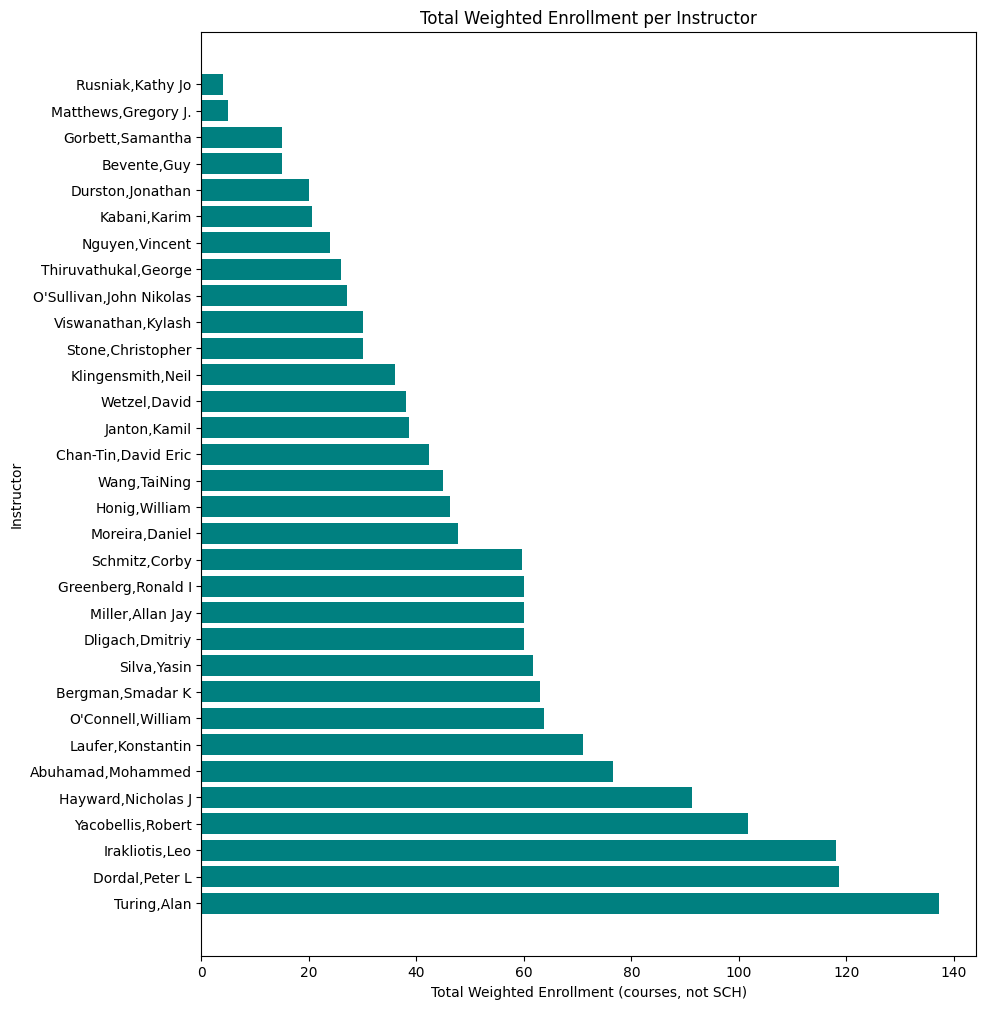

In [ ]:

df = df2

total_enrollment = df.groupby('INSTRUCTOR')['WEIGHTED_ENROLL_TOTAL'].sum().reset_index()


# Sort data for better visualization (optional)
total_enrollment = total_enrollment.sort_values(by='WEIGHTED_ENROLL_TOTAL', ascending=False)

# Plotting
plt.figure(figsize=(10, 12))  # Adjust the size of the plot as needed
plt.barh(total_enrollment['INSTRUCTOR'], total_enrollment['WEIGHTED_ENROLL_TOTAL'], color='teal')
plt.xlabel('Total Weighted Enrollment (courses, not SCH)')
plt.ylabel('Instructor')
plt.title('Total Weighted Enrollment per Instructor')

plt.show()


## Enrollments by Course Level (e.g. 100, 200, 300, 400, etc.)

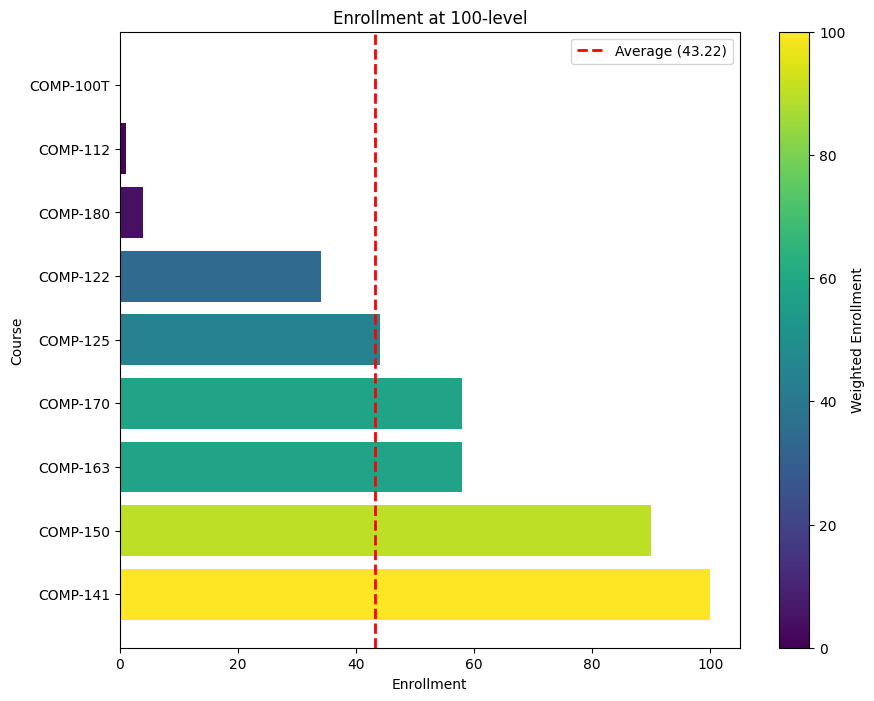

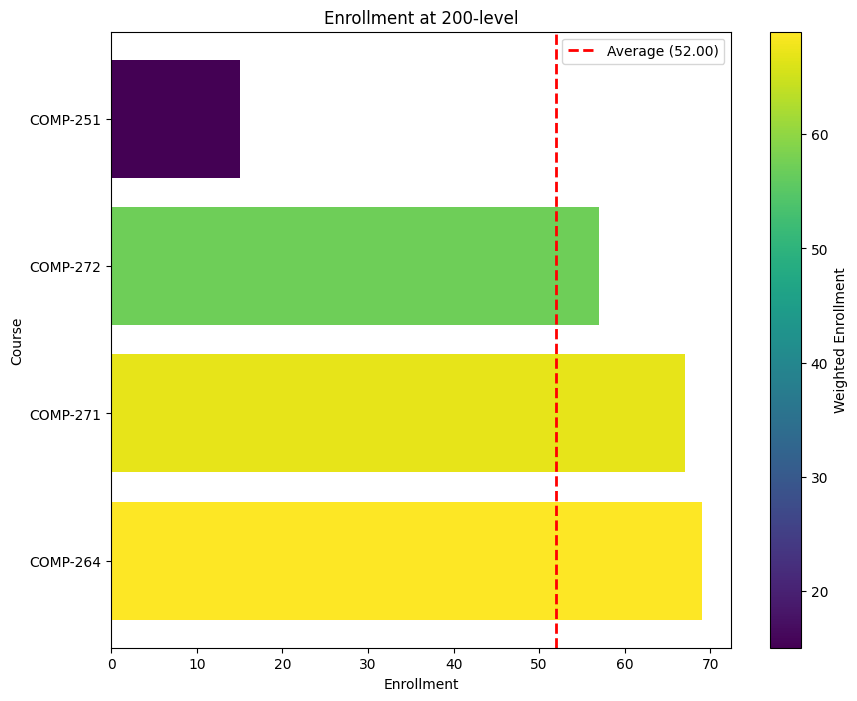

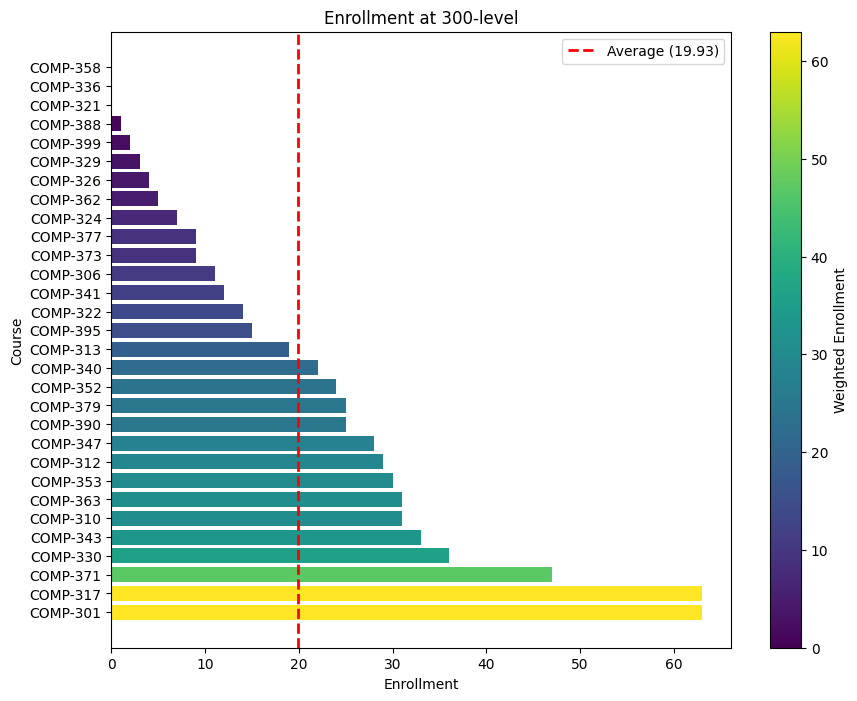

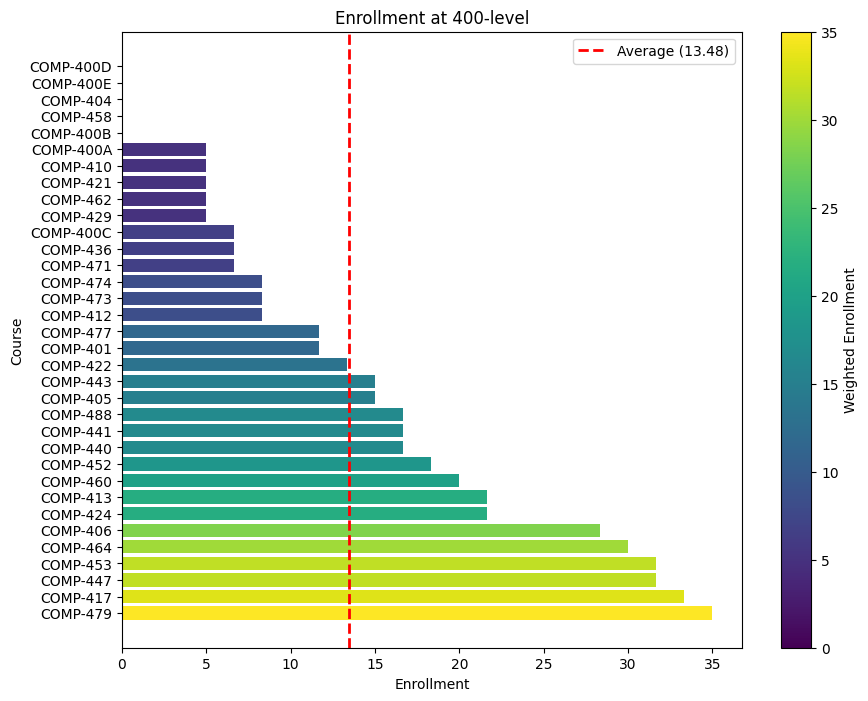

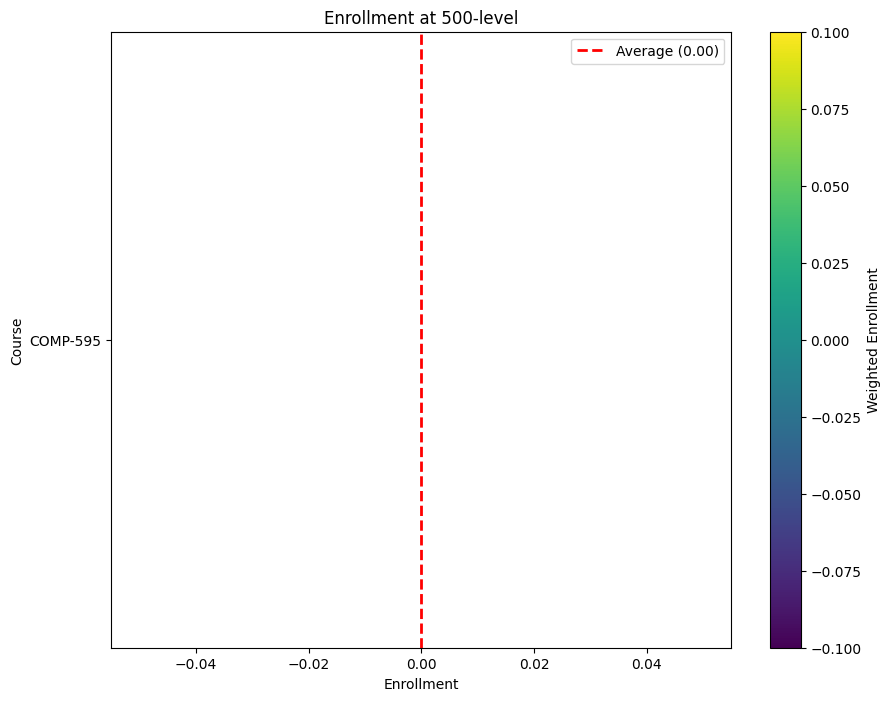

In [ ]:
import matplotlib.colors as mcolors

for level in range(0, 500, 100):
  this_level = str(level + 100)
  df = df2[ df2['CATALOG_NUMBER'] >= this_level]
  next_level = str(level + 200)
  df = df[ df['CATALOG_NUMBER'] < next_level]

  if len(df) == 0:
    break


  course_enrollment = df.groupby('FQ_CATALOG_NUMBER')['WEIGHTED_ENROLL_TOTAL'].sum().reset_index()
  course_enrollment = course_enrollment.sort_values(by='WEIGHTED_ENROLL_TOTAL', ascending=False)

  # Plotting

  fig, ax = plt.subplots(figsize=(10, 8))

#  plt.figure(figsize=(10, 6))

  # Normalize the Weighted Enrollment to map to the colormap
  norm = mcolors.Normalize(vmin=course_enrollment['WEIGHTED_ENROLL_TOTAL'].min(), vmax=course_enrollment['WEIGHTED_ENROLL_TOTAL'].max())
  colors = plt.cm.viridis(norm(course_enrollment['WEIGHTED_ENROLL_TOTAL']))

  plt.barh(course_enrollment['FQ_CATALOG_NUMBER'], course_enrollment['WEIGHTED_ENROLL_TOTAL'], color=colors)
  plt.xlabel('Enrollment')
  plt.ylabel('Course')
  plt.title(f'Enrollment at {this_level}-level')

  # Calculate and plot the average weighted enrollment
  average_enrollment = course_enrollment['WEIGHTED_ENROLL_TOTAL'].mean()
  plt.axvline(average_enrollment, color='red', linestyle='--', linewidth=2, label=f'Average ({average_enrollment:.2f})')

  # Add a legend and colorbar
  plt.legend()
  sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
  sm.set_array([])
  plt.colorbar(sm, ax=ax, orientation='vertical', label='Weighted Enrollment')


  plt.savefig(f'enrollment-{this_level}.pdf')
  plt.savefig(f'enrollment-{this_level}.png')
  plt.show()



# End

Enjoy!